In [22]:
import os
import pickle
import sys

import alphashape
import geotiff as gt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapefile
from descartes import PolygonPatch

sys.path.append("../")

In [2]:
from utils import from_pickle, to_pickle

In [3]:
os.makedirs("outputs/", exist_ok=True)

In [4]:
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["axes.grid"] = True

In [5]:
GEOPHYS_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geophys/"
GEOCHEM_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/Geochem/"
GEO_DIR = "D:/03 UofA/02 Code/MPM/QUEST Northwest/BC_digital_geology_shp/"

# GeoTiffs

In [6]:
total_mag = gt.GeoTiff(GEOPHYS_DIR + "QNWB1_TMI_25m.tif", as_crs=26909)
vert_deriv = gt.GeoTiff(GEOPHYS_DIR + "QNWB1_1VD_25m.tif", as_crs=26909)

In [7]:
# generate shapefile polygon for clipping
w = shapefile.Writer("shapefile/bbox_polygon")
w.field("name", "C")
w.poly(
    [
        [
            [*total_mag.tif_bBox[0]],  # top left
            [total_mag.tif_bBox[1][0], total_mag.tif_bBox[0][1]],  # top right
            [*total_mag.tif_bBox[1]],  # bottom right
            [total_mag.tif_bBox[0][0], total_mag.tif_bBox[1][1]],  # bottom left
        ]
    ]
)
w.record("polygon1")
w.close()

In [8]:
mag_array_rgb = np.array(total_mag.read())
deriv_array_rgb = np.array(vert_deriv.read())

# convert to grayscale and normalize
mag_array_gray = np.mean(mag_array_rgb, axis=-1, keepdims=True) / 255
deriv_array_gray = np.mean(deriv_array_rgb, axis=-1, keepdims=True) / 255

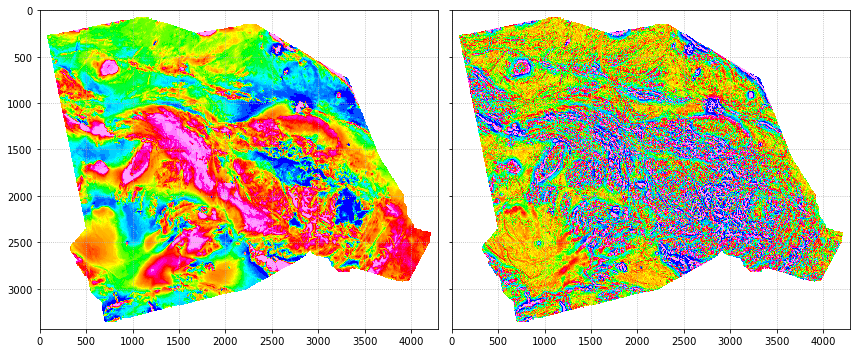

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey="all", sharex="all")
ax[0].imshow(mag_array_rgb)
ax[1].imshow(deriv_array_rgb)
fig.tight_layout()

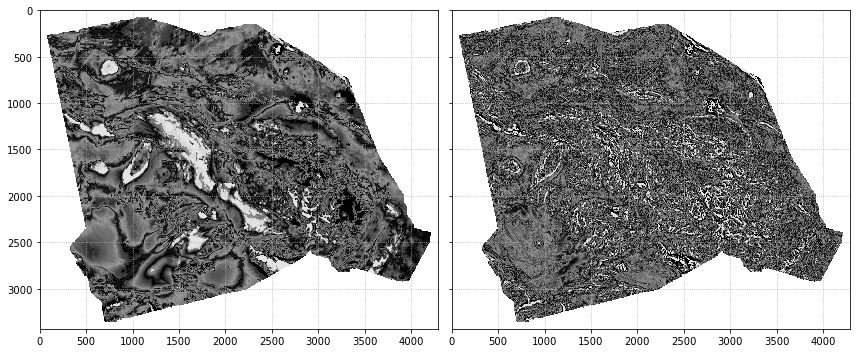

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey="all", sharex="all")
ax[0].imshow(mag_array_gray[:,:,0], cmap="Greys_r")
ax[1].imshow(deriv_array_gray[:,:,0], cmap="Greys_r")
fig.tight_layout()

In [11]:
geophys_channels = {
    "total_mag": mag_array_gray,
    "vert_deriv": deriv_array_gray,
}

In [12]:
# tensor shapes
for key, value in geophys_channels.items():
    print(key + " shape:", value.shape)

total_mag shape: (3433, 4287, 1)
vert_deriv shape: (3433, 4287, 1)


In [13]:
to_pickle("./outputs/geophys_channels.pkl", geophys_channels)

# Keyout

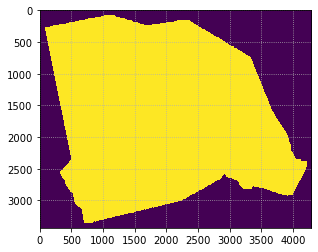

In [14]:
mask = mag_array_gray[:,:,0] < 1
plt.imshow(mask)

In [15]:
with open("./outputs/keyout.pkl", "wb") as fp:
    pickle.dump(mask, fp)

# Alpha Shape

26909


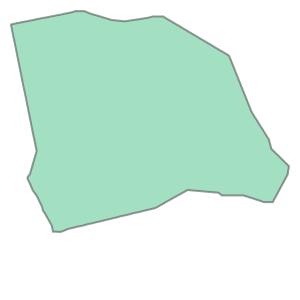

In [17]:
total_mag_coarse = gt.GeoTiff(GEOPHYS_DIR + "QNWB1_TMI.tif", as_crs=26909)
mag_array_coarse = np.array(total_mag_coarse.read())
mag_array_gray_coarse = np.mean(mag_array_coarse, axis=-1, keepdims=True) / 255
mask_coarse = mag_array_gray_coarse[:,:,0] < 1

x_arr, y_arr = total_mag_coarse.get_coord_arrays()
points = [*zip(x_arr[mask_coarse].flatten(), y_arr[mask_coarse].flatten())]
alpha_shape = alphashape.alphashape(points, 0.0001)
alpha_shape

In [18]:
print(f"{int(alpha_shape.area/1000):,}")

5,866,910


In [19]:
bound_x, bound_y = alpha_shape.exterior.coords.xy

In [20]:
# generate shapefile polygon for clipping
w = shapefile.Writer("shapefile/bbox_geophys")
w.field("name", "C")
w.poly([[*zip(bound_x, bound_y)]])
w.record("polygon1")
w.close()

In [21]:
to_pickle("./outputs/boundary_poly.pkl", alpha_shape)